# PR-015 CNN_Sentence_Classification

곽근봉 님의 [CNN_Sentence_Classification 강의](https://www.youtube.com/watch?v=IRB2vXSet2E&index=16&list=PLlMkM4tgfjnJhhd4wn5aj8fVTYJwIpWkS) 감사드립니다.

pretrain 되어진 word2vec을 활용하여 Sentence 분류를 해 봅니다.

논문에서 언급한 4가지 버전을 모두 구현하지 않고

**non-static** 한 방법을 사용합니다.

Deep Learning with Keras - 저자 : Antonio Gulli

를 참고하였습니다.

논문: http://aclweb.org/anthology/D14-1181

### Prerequisite

<code>pip install genism</code>

<code>pip install wget</code>

<code>pip install scikit-learn</code>

### Hyperparameters

In [1]:
VOCAB_SIZE = 5000     # 데이터 셋에서 상위 5000 개의 토큰만 고려할 것입니다.
EMBED_SIZE = 300      # 임베딩 크기는 300 을 사용할 것입니다.
BATCH_SIZE = 64
EPOCHS = 20

### Dataset

Kaggle 의 [SI 650 sentiment classification](https://www.kaggle.com/c/si650winter11/data) 데이터를 활용합니다.

약 7000개의 문장이 있고 긍정은 1, 부정은 0 입니다.

데이터를 다운로드 누르면 브라우저 상에서 텍스트들이 보일 겁니다.

training.txt 파일을 생성하고 브라우저의 텍스트를 모두 복붙합니다.

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/anthony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from collections import Counter, defaultdict

maxlen = 0
counter = Counter()
train_file = open('training.txt', 'r', encoding='utf-8')

for line in train_file:
    _, sentence = line.strip().split("\t")      # 텝을 기준으로 split 합니다.
    
    words = []
    for token in nltk.word_tokenize(sentence):  # 문장을 단어 단위로 쪼갭니다.
        words.append(token.lower())               # 단어를 모두 소문자로 만들어 줍니다.
    
    if len(words) > maxlen:
        maxlen = len(words)                     # 문장의 최대 단어 개수를 측정합니다. 추후 패딩할 때 사용합니다.
    
    for word in words:
        counter[word] += 1                      # 모든 단어의 출현 횟수를 기록합니다.

train_file.close()

word2index = defaultdict(int)
for i, word in enumerate(counter.most_common(VOCAB_SIZE)):  # 가장 자주 나온 단어들만을 고려합니다.
    word2index[word[0]] = i + 1                             # unknown data의 index 는 0 입니다.
    
index2word = {v:k for k, v in word2index.items()}

In [4]:
# 이제 각 문장을 maxlen만큼 padding 시킵니다.
# keras 의 pad_sequence를 사용하면 간편합니다.
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

X, Y = [], []
train_file = open('training.txt', 'r', encoding='utf-8')

for line in train_file:
    label, sentence = line.strip().split("\t")
    
    words = []
    for token in nltk.word_tokenize(sentence):    # 문장을 단어 단위로 쪼갭니다.
        words.append(token.lower())               # 단어를 모두 소문자로 만들어 줍니다.
    
    wids = []
    for word in words:
        wids.append(word2index[word])
        
    X.append(wids)
    Y.append(int(label))
    
train_file.close()

X = pad_sequences(X, maxlen=maxlen)
Y = to_categorical(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

Using TensorFlow backend.


### Pretrained Word2Vec

구글 뉴스 데이터셋에서 100억 단어 이상에 대해 학습한 모델을 가져옵니다.

vocab 크기는 300만 단어이고 임베딩 차원은 300 입니다.

가장 먼저 데이터를 [다운로드](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) 받습니다.

현재 프로젝트 폴더에 압축을 풀어 주세요.

In [5]:
from gensim.models import KeyedVectors
import numpy as np

# C binary 형태로 pretrain 데이터를 읽어옵니다.
word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

# weight를 추출합니다.
embedding_weights = np.zeros((len(word2index) + 1, EMBED_SIZE))
for word, index in word2index.items():
    try:
        embedding_weights[index, :] = word2vec[word]       # 구글 뉴스 word2vec에 포함된 단어만 가져옵니다.
    except KeyError:                                       # 포함되지 않아, keyerror 가 발생한다면 0 그대로 둡니다.
        pass              

### Model Build & Train

In [10]:
from keras.layers.core import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential

model = Sequential()
model.add(Embedding(len(word2index) + 1, EMBED_SIZE, 
                    input_length=maxlen,
                    weights=[embedding_weights],
                    trainable=True))

model.add(Conv1D(256, kernel_size=3, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, Y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, Y_test))

Train on 4615 samples, validate on 1979 samples
Epoch 1/20
4615/4615 [==============================] - 13s 3ms/step - loss: 0.1081 - acc: 0.9627 - val_loss: 0.0227 - val_acc: 0.9919
Epoch 2/20
4615/4615 [==============================] - 13s 3ms/step - loss: 0.0084 - acc: 0.9983 - val_loss: 0.0175 - val_acc: 0.9949
Epoch 3/20
4615/4615 [==============================] - 13s 3ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0175 - val_acc: 0.9934
Epoch 4/20
4615/4615 [==============================] - 13s 3ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 0.9944
Epoch 5/20
4615/4615 [==============================] - 13s 3ms/step - loss: 5.9346e-04 - acc: 1.0000 - val_loss: 0.0182 - val_acc: 0.9939
Epoch 6/20
4615/4615 [==============================] - 13s 3ms/step - loss: 4.1120e-04 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 0.9939
Epoch 7/20
4615/4615 [==============================] - 13s 3ms/step - loss: 2.7378e-04 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.

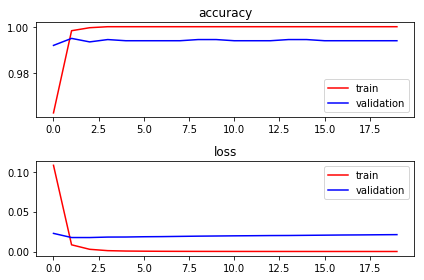

In [11]:
# trainmatplotlib.pyplot화를 출력해 봅니다.

import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### DO! IT! yourself

In [16]:
# 직접 문장을 만들어서 모델의 결과를 봅시다.

sentence = 'I loved Boston and MIT so much and still do.'
words = sentence.split()

wids = []
for word in words:
    wids.append(word2index[word])

my_test = pad_sequences([wids], maxlen=maxlen)

model.predict(my_test)

array([[  4.70524756e-05,   9.99952912e-01]], dtype=float32)

## Contact me
케라스를 사랑하는 개발자 입니다.

질문, 조언, contribtuion 등 소통은 언제나 환영합니다.

Anthony Kim(김동현) : artit.anthony@gmail.com